# Machine Learning on a Public Dataset

Train and Evaluate the machine learning models

## Importing the Required Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
# local modules
from src.data_pipeline import data_pipeline
from src.models import UNet, DeepLabv4
from src.utils import train_and_evaluate

## Visualizing CossineAnnealing Learning Rate Scheduler

In [ ]:
dummy_model = torch.nn.Sequential(torch.nn.Linear(32, 32))
dummy_opt = torch.optim.RAdam(dummy_model.parameters())
dummy_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(dummy_opt, T_max=30)

lrs = []
for ep in range(30):
    lrs.append(dummy_scheduler.get_last_lr())
    dummy_opt.step()
    dummy_scheduler.step()

plt.plot(lrs)
plt.show()

## Train & Evaluate U-Net with no Augmentation for Baseline

In [ ]:
model = UNet(3, 1)
train_and_evaluate(model, 'unet', augment=False, oversample=False)

## Visual validation of the Model Prediction

In [ ]:
path = "./dataset/test/TCGA_CS_4941_19960909_15.tif"
img = cv2.imread(path)
transform = data_pipeline(False)
img = transform(image=img)
img = img['image']
img = img.unsqueeze(0) / 255
assert img.shape == (1, 3, 256, 256) and img.dtype == torch.float32
model = torch.load('models/unet.pth').eval()
pred = (model(img.to(torch.device('cuda'))) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0).squeeze(0)
assert pred.shape == (256, 256)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
img = cv2.imread(path)
ax1.imshow(img)
ax2.imshow(pred, cmap='gray')
plt.show()

## Training and Evaluating Attention-Gated U-Net

In [ ]:
model = UNet(3, 1, attention_gate=True)
train_and_evaluate(model, 'attention_gate_unet', augment=True, oversample=False)

## Visual validation of the Model Prediction

In [ ]:
path = "./dataset/test/TCGA_CS_4941_19960909_15.tif"
img = cv2.imread(path)
transform = data_pipeline(False)
img = transform(image=img)
img = img['image']
img = img.unsqueeze(0) / 255
assert img.shape == (1, 3, 256, 256) and img.dtype == torch.float32
model = torch.load('models/attention_gate_unet.pth').eval()
pred = (model(img.to(torch.device('cuda'))) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0).squeeze(0)
assert pred.shape == (256, 256)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
img = cv2.imread(path)
ax1.imshow(img)
ax2.imshow(pred, cmap='gray')
plt.show()

## Training and Evaluating U-Net with Deformable Convolution

In [ ]:
model = UNet(3, 1, attention_gate=False, dcn=True)
train_and_evaluate(model, 'deformable_unet', augment=True, oversample=False)

## Visual validation of the Model Prediction

In [ ]:
path = "./dataset/test/TCGA_CS_4941_19960909_15.tif"
img = cv2.imread(path)
transform = data_pipeline(False)
img = transform(image=img)
img = img['image']
img = img.unsqueeze(0) / 255
assert img.shape == (1, 3, 256, 256) and img.dtype == torch.float32
model = torch.load('models/deformable_unet.pth').eval()
pred = (model(img.to(torch.device('cuda'))) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0).squeeze(0)
assert pred.shape == (256, 256)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
img = cv2.imread(path)
ax1.imshow(img)
ax2.imshow(pred, cmap='gray')
plt.show()

## Training and Evaluating DeepLabv4

In [2]:
model = DeepLabv4(3, 1)
train_and_evaluate(model, 'deeplabv4', augment=True, oversample=False)

--------- Epoch 1 ---------
Current learning rate: 0.00100


49it [00:14,  3.34it/s]


[Train]  Loss: 0.9702
[Test]  Loss: 0.9582 mIoU: 0.0738 Precision: 0.0738 Recall: 1.0000 F1: 0.0920
--------- Epoch 2 ---------
Current learning rate: 0.00100


49it [00:13,  3.64it/s]


[Train]  Loss: 0.8653
[Test]  Loss: 0.8083 mIoU: 0.5265 Precision: 0.6223 Recall: 0.8788 F1: 0.5647
--------- Epoch 3 ---------
Current learning rate: 0.00099


49it [00:13,  3.57it/s]


[Train]  Loss: 0.6604
[Test]  Loss: 0.5938 mIoU: 0.6195 Precision: 0.6965 Recall: 0.8971 F1: 0.6619
--------- Epoch 4 ---------
Current learning rate: 0.00098


49it [00:13,  3.58it/s]


[Train]  Loss: 0.4274
[Test]  Loss: 0.6746 mIoU: 0.7174 Precision: 0.9874 Recall: 0.7240 F1: 0.7364
--------- Epoch 5 ---------
Current learning rate: 0.00096


49it [00:13,  3.60it/s]


[Train]  Loss: 0.3576
[Test]  Loss: 0.4599 mIoU: 0.7666 Precision: 0.9395 Recall: 0.8131 F1: 0.7986
--------- Epoch 6 ---------
Current learning rate: 0.00093


49it [00:13,  3.57it/s]


[Train]  Loss: 0.2953
[Test]  Loss: 0.4812 mIoU: 0.7535 Precision: 0.9410 Recall: 0.8032 F1: 0.7806
--------- Epoch 7 ---------
Current learning rate: 0.00090


49it [00:13,  3.50it/s]


[Train]  Loss: 0.2968
[Test]  Loss: 0.3467 mIoU: 0.7951 Precision: 0.9241 Recall: 0.8569 F1: 0.8282
--------- Epoch 8 ---------
Current learning rate: 0.00087


49it [00:13,  3.58it/s]


[Train]  Loss: 0.3046
[Test]  Loss: 0.4561 mIoU: 0.7682 Precision: 0.9504 Recall: 0.8068 F1: 0.7969
--------- Epoch 9 ---------
Current learning rate: 0.00083


49it [00:14,  3.48it/s]


[Train]  Loss: 0.2848
[Test]  Loss: 0.4446 mIoU: 0.7754 Precision: 0.9310 Recall: 0.8356 F1: 0.8038
--------- Epoch 10 ---------
Current learning rate: 0.00079


49it [00:13,  3.55it/s]


[Train]  Loss: 0.2764
[Test]  Loss: 0.4115 mIoU: 0.7038 Precision: 0.7983 Recall: 0.8944 F1: 0.7398
--------- Epoch 11 ---------
Current learning rate: 0.00075


49it [00:13,  3.57it/s]


[Train]  Loss: 0.2463
[Test]  Loss: 0.3459 mIoU: 0.7812 Precision: 0.9097 Recall: 0.8557 F1: 0.8172
--------- Epoch 12 ---------
Current learning rate: 0.00070


49it [00:13,  3.56it/s]


[Train]  Loss: 0.2337
[Test]  Loss: 0.3836 mIoU: 0.7982 Precision: 0.9281 Recall: 0.8606 F1: 0.8292
--------- Epoch 13 ---------
Current learning rate: 0.00065


49it [00:13,  3.55it/s]


[Train]  Loss: 0.2356
[Test]  Loss: 0.3880 mIoU: 0.7796 Precision: 0.9005 Recall: 0.8648 F1: 0.8119
--------- Epoch 14 ---------
Current learning rate: 0.00060


49it [00:13,  3.51it/s]


[Train]  Loss: 0.2134
[Test]  Loss: 0.3537 mIoU: 0.7833 Precision: 0.9128 Recall: 0.8608 F1: 0.8159
--------- Epoch 15 ---------
Current learning rate: 0.00055


49it [00:13,  3.54it/s]


[Train]  Loss: 0.2125
[Test]  Loss: 0.3048 mIoU: 0.8145 Precision: 0.9158 Recall: 0.8875 F1: 0.8471
--------- Epoch 16 ---------
Current learning rate: 0.00050


49it [00:13,  3.54it/s]


[Train]  Loss: 0.1939
[Test]  Loss: 0.3182 mIoU: 0.8175 Precision: 0.9186 Recall: 0.8857 F1: 0.8510
--------- Epoch 17 ---------
Current learning rate: 0.00045


49it [00:13,  3.56it/s]


[Train]  Loss: 0.1881
[Test]  Loss: 0.3490 mIoU: 0.8065 Precision: 0.9154 Recall: 0.8796 F1: 0.8378
--------- Epoch 18 ---------
Current learning rate: 0.00040


49it [00:13,  3.55it/s]


[Train]  Loss: 0.1877
[Test]  Loss: 0.2986 mIoU: 0.7987 Precision: 0.9041 Recall: 0.8823 F1: 0.8325
--------- Epoch 19 ---------
Current learning rate: 0.00035


49it [00:13,  3.51it/s]


[Train]  Loss: 0.1826
[Test]  Loss: 0.3746 mIoU: 0.8014 Precision: 0.9530 Recall: 0.8394 F1: 0.8298
--------- Epoch 20 ---------
Current learning rate: 0.00030


49it [00:13,  3.53it/s]


[Train]  Loss: 0.1746
[Test]  Loss: 0.2247 mIoU: 0.8342 Precision: 0.9091 Recall: 0.9118 F1: 0.8696
--------- Epoch 21 ---------
Current learning rate: 0.00025


49it [00:13,  3.55it/s]


[Train]  Loss: 0.1751
[Test]  Loss: 0.2286 mIoU: 0.8161 Precision: 0.8762 Recall: 0.9275 F1: 0.8539
--------- Epoch 22 ---------
Current learning rate: 0.00021


49it [00:13,  3.54it/s]


[Train]  Loss: 0.1558
[Test]  Loss: 0.2899 mIoU: 0.8209 Precision: 0.9175 Recall: 0.8930 F1: 0.8547
--------- Epoch 23 ---------
Current learning rate: 0.00017


49it [00:13,  3.53it/s]


[Train]  Loss: 0.1606
[Test]  Loss: 0.2660 mIoU: 0.8280 Precision: 0.9254 Recall: 0.8921 F1: 0.8597
--------- Epoch 24 ---------
Current learning rate: 0.00013


49it [00:13,  3.51it/s]


[Train]  Loss: 0.1503
[Test]  Loss: 0.2261 mIoU: 0.8332 Precision: 0.9103 Recall: 0.9105 F1: 0.8688
--------- Epoch 25 ---------
Current learning rate: 0.00010


49it [00:14,  3.47it/s]


[Train]  Loss: 0.1515
[Test]  Loss: 0.2154 mIoU: 0.8423 Precision: 0.9322 Recall: 0.8993 F1: 0.8756
--------- Epoch 26 ---------
Current learning rate: 0.00007


49it [00:14,  3.36it/s]


[Train]  Loss: 0.1403
[Test]  Loss: 0.2145 mIoU: 0.8397 Precision: 0.9182 Recall: 0.9100 F1: 0.8745
--------- Epoch 27 ---------
Current learning rate: 0.00004


49it [00:14,  3.47it/s]


[Train]  Loss: 0.1463
[Test]  Loss: 0.2163 mIoU: 0.8356 Precision: 0.9058 Recall: 0.9182 F1: 0.8709
--------- Epoch 28 ---------
Current learning rate: 0.00002


49it [00:13,  3.53it/s]


[Train]  Loss: 0.1404
[Test]  Loss: 0.2177 mIoU: 0.8394 Precision: 0.9199 Recall: 0.9083 F1: 0.8740
--------- Epoch 29 ---------
Current learning rate: 0.00001


49it [00:13,  3.54it/s]


[Train]  Loss: 0.1467
[Test]  Loss: 0.2143 mIoU: 0.8416 Precision: 0.9189 Recall: 0.9116 F1: 0.8765
--------- Epoch 30 ---------
Current learning rate: 0.00000


49it [00:14,  3.48it/s]


[Train]  Loss: 0.1413
[Test]  Loss: 0.2146 mIoU: 0.8395 Precision: 0.9166 Recall: 0.9113 F1: 0.8747


## Visual validation of the Model Prediction

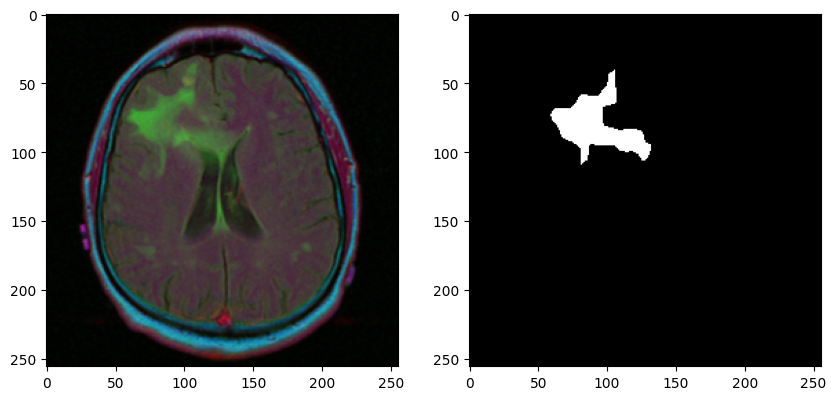

In [3]:
path = "./dataset/test/TCGA_CS_4941_19960909_15.tif"
img = cv2.imread(path)
transform = data_pipeline(False)
img = transform(image=img)
img = img['image']
img = img.unsqueeze(0) / 255
assert img.shape == (1, 3, 256, 256) and img.dtype == torch.float32
model = torch.load('models/deeplabv4.pth').eval()
pred = (model(img.to(torch.device('cuda'))) > 0.5).float()
assert pred.shape == (1, 1, 256, 256)
pred = pred.squeeze(0).squeeze(0)
assert pred.shape == (256, 256)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
img = cv2.imread(path)
ax1.imshow(img)
ax2.imshow(pred, cmap='gray')
plt.show()